In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from utils.PPCA_utils import make_meshgrid, \
                        mahalanobis_distance, \
                        clean_nans, \
                        undo_nan_cleanup, \
                        extract_missing_ind_pairs, \
                        extract_bp_idx, \
                        get_PCA_params, \
                        plot_coords_views, \
                        create_ind_list

In [2]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose'

In [3]:
plot_folder = "../PCA_infill/figs"

### Data loading and preprocessing

Load ground-truth labels, which you'll have to preprocess using the designated `get_data()` module, including offsetting (not sure). 
represent a given frame as a matrix `(num_views * 2, num_bodyparts* num_frames)` while we wish to represent it as `(3, num_bodyparts)` as a 3D world. 

In [4]:
hf = h5py.File('../Video_Datasets/Sawtell-data/tank_dataset_11.h5', 
               'r')

In [5]:
print(hf.keys())

<KeysViewHDF5 ['annotated', 'annotations', 'frame_number', 'images', 'skeleton', 'skeleton_names', 'video_name']>


In [6]:
images = hf['images']
images

<HDF5 dataset "images": shape (263, 384, 512, 1), type "|u1">

In [7]:
labels = hf["annotations"] # can add np.array
labels.shape

(263, 108, 2)

In [8]:
# decode binary to ASCII
skeleton_name_list = [i.decode('UTF-8') for i in list(hf["skeleton_names"])]

In [9]:
bp_to_keep = ["chin", "chin1", "chin3", "mid", "head", "caudal", "tail"]
view_names = ["top", "main", "right"]

below, parsing the right names

In [10]:
multiview_idx_to_name, multiview_name_to_idx, new_skeleton_names = extract_bp_idx(skeleton_name_list, 
                  view_names,
                  bp_to_keep)

In [11]:
num_analyzed_body_parts = int(len(new_skeleton_names) / len(view_names))
num_analyzed_body_parts

10

In [12]:
if len(bp_to_keep) > 0:
    num_analyzed_body_parts = int(len(new_skeleton_names) / len(view_names))

pts_array = labels
offset = False
# (num views, num frames, num points per frame, 2)
pts_array_2d_joints = np.empty(
    shape=(len(view_names), pts_array.shape[0], num_analyzed_body_parts, 2)
)


for i, view_name in enumerate(view_names):
    # Select rows from indices
    view_indices = multiview_name_to_idx[view_name]
    view_points = pts_array[:, view_indices, :]
    if offset:
        # ToDo: make sure we can access img_settings
        view_points[:, :, 0] -= img_settings["width_lims"][i][0]
        view_points[:, :, 1] -= img_settings["height_lims"][i][0]
    pts_array_2d_joints[i, :, :, :] = view_points

In [13]:
# we were doing this previously (keeping it for now)
pts_2d = pts_array_2d_joints.reshape(
        pts_array_2d_joints.shape[0],
        pts_array_2d_joints.shape[1] * pts_array_2d_joints.shape[2],
        pts_array_2d_joints.shape[3],
    )
print(pts_2d.shape) 

(3, 2630, 2)


In [14]:
#from utils.utils_BA import clean_nans
# ToDo: not sure that my cleanup makes sense (we remove bp on certain frames, but these are like independet observations so maybe ok)
pts_2d_filtered, clean_point_indices = clean_nans(pts_2d, True) 
#pts_2d_filtered

In [15]:
arr_for_pca = np.concatenate((pts_2d_filtered[:,:,0], 
                            pts_2d_filtered[:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
arr_for_pca.shape

(6, 1751)

## Vanilla PCA with 3 dims

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(arr_for_pca.T)

PCA(n_components=3, svd_solver='full')

In [18]:
print(np.sum(pca.explained_variance_ratio_))

0.8959086437535417


In [19]:
reduced_data = pca.transform(arr_for_pca.T)
reduced_data.shape

(1751, 3)

In [20]:
pca_preds = pca.inverse_transform(reduced_data)
pca_preds.shape # same shape as arr_for_pca.T

(1751, 6)

now we have to work our way back to the data

In [21]:
pca_preds = pca_preds.T
pca_preds.shape

(6, 1751)

In [22]:
expanded_preds = np.expand_dims(pca_preds,-1)
expanded_preds.shape

(6, 1751, 1)

In [23]:
expanded_preds = np.expand_dims(pca_preds,-1)
recon_filtered_pts_2d = np.concatenate(
    (expanded_preds[:len(view_names), :,:],
    expanded_preds[len(view_names):, :,:]), axis=-1)
recon_filtered_pts_2d.shape # ToDo: check that the undoing of arr_for_pca is fine itself

(3, 1751, 2)

In [24]:
preds_reverted = undo_nan_cleanup(pts_2d, 
                              clean_point_indices, 
                              recon_filtered_pts_2d)

In [25]:
preds_reverted.shape == pts_2d.shape

True

In [26]:
pts_2d.shape

(3, 2630, 2)

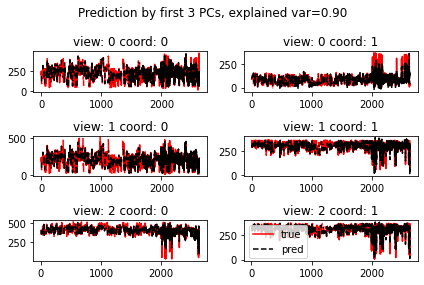

In [28]:
title = 'Prediction by first %i PCs, explained var=%.2f' % (pca.n_components, np.sum(pca.explained_variance_ratio_))
plot_coords_views(pts_2d, preds_reverted, title)
plt.savefig(os.path.join(plot_folder, 
                        'preds_by_%i_pc_fish.png' % pca.n_components))

In [29]:
# TODO: check these couple of lines, maybe redundant
pts_2d_reshaped = pts_2d.reshape(pts_array_2d_joints.shape)
preds_reshaped = preds_reverted.reshape(pts_array_2d_joints.shape)

In [30]:
preds_reshaped.shape

(3, 263, 10, 2)

In [31]:
points_dir = Path("./PCA_reproj").resolve()
points_dir.mkdir(parents=True, exist_ok=True)

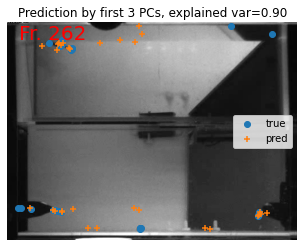

In [48]:
#images.shape
# ToDo -- use one of the existing functions to plot an image + scatter
for i in range(preds_reshaped.shape[1]):
    plt.cla()
    plt.axis('off')
    plt.imshow(images[i,:,:,0], "gray")
    plt.scatter(pts_2d_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten())
    plt.scatter(preds_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten(), marker = '+')
    plt.legend(["true", "pred"])
    plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
    plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 20)
    plt.savefig(points_dir / ('im_%04d.png' %i))
    plt.xlabels = []

In [49]:
# make video from these images
image_folder = points_dir
import cv2
import os
im_list = os.listdir(image_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(image_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('video_PC_3.mov',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      2, size) # 
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## P-PCA / Factor analysis

In [32]:
# run vanilla PCA keeping all 2K components
pca = PCA(n_components=6, svd_solver='full')
pca.fit(arr_for_pca.T)
num_PCs = 3 # M

In [33]:
params = get_PCA_params(pca, num_PCs, arr_for_pca, "LP")

In [34]:
pca.explained_variance_

array([13798.44739609,  4631.693368  ,  3215.83600815,  1276.81117751,
         651.28911794,   586.84260102])

In [36]:
#for val in params.values():
#    print(val.shape)
#for key in params.keys():
#    print(key)

In [37]:
# parametrizing by precision
from LinearGaussianModel import LinearGaussianModel
LG_model = LinearGaussianModel(params['prior_mean'], 
                              params['prior_precision'], 
                               params['obs_projection'], 
                               params['obs_offset'], 
                               params['obs_precision'])
LG_model.simplify_posterior = False

In [38]:
plot_folder = "../PCA_infill/figs"

In [39]:
# loop over frames and bodyparts get pred_mean and pred_cov for each. then decide what to plot
arr_for_test = np.concatenate((pts_2d_reshaped[:,:,:,0], 
                            pts_2d_reshaped[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
print(arr_for_test.shape)
arr_squeezed = arr_for_test.reshape(6,-1)
print(arr_squeezed.shape)

(6, 263, 10)
(6, 2630)


In [40]:
# loop over datapoints, compute posterior, and predict.
post_mean_arr = np.zeros((num_PCs, arr_squeezed.shape[1]))
post_cov_arr = np.zeros((num_PCs, num_PCs, arr_squeezed.shape[1]))
pred_mean = np.zeros_like(arr_squeezed)
pred_cov = np.zeros((arr_squeezed.shape[0],
                     arr_squeezed.shape[0], 
                     arr_squeezed.shape[1]))
for i in range(arr_squeezed.shape[1]):
    # compute posterior
    post_mean, post_cov = LG_model.compute_posterior(arr_squeezed[:,i]) # a single frame and body part
    post_mean_arr[:,i], post_cov_arr[:,:,i] = post_mean.squeeze(), post_cov
    # predict
    mean, cov = LG_model.predict(post_mean, post_cov, False)
    pred_mean[:,i], pred_cov[:,:,i] = mean.squeeze(), cov

In [41]:
pred_mean_reshaped = pred_mean.reshape(arr_for_test.shape)
pred_cov_reshaped = pred_cov.reshape(arr_for_test.shape[0], 
                                     arr_for_test.shape[0], 
                                     arr_for_test.shape[1], 
                                     arr_for_test.shape[2])

In [42]:
counts = np.array([0, 2, 4, 6])
strs = ["miss %i/%i" % (i, counts[-1]) for i in counts]
strs

['miss 0/6', 'miss 2/6', 'miss 4/6', 'miss 6/6']

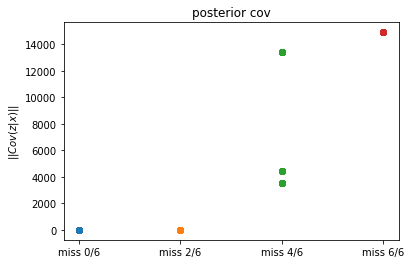

In [43]:
#missing_obs_bool = np.zeros(len(counts), np.shape(arr_squeezed[-1]))
for i in range(len(counts)):
    missing_obs_bool = np.sum(np.isnan(arr_squeezed), axis=0)==counts[i]
    post_missing = post_cov_arr[:,:,missing_obs_bool]
    norms_missing = np.linalg.norm(post_missing, axis=(0,1))
    plt.scatter(np.ones(len(norms_missing))*counts[i], norms_missing)
    missing_obs_bool = np.sum(np.isnan(arr_squeezed), axis=0)>0
plt.xticks(counts, labels = strs)
plt.ylabel(r"$||Cov(z|x)||$")
plt.title('posterior cov')
plt.savefig(os.path.join(plot_folder, 'post_cov.png'))

In [44]:
#from cycler import cycler
#import matplotlib as mpl
#n = 10 # num_bodyparts
#color = plt.cm.Set1(np.linspace(0, 1,n)) # choose a qualitative discrete one
#len(color)
#mpl.rcParams['axes.prop_cycle'] = cycler('color', color)

In [45]:
# for 10 bps. the above cell is less manusl
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

In [46]:
len(color)

10

In [47]:
pred_plot_params_dict = {}
pred_plot_params_dict["ellipse_method"] = "mahalanobis" # or "chi_2"
pred_plot_params_dict["ellipse_method_param"] = 3.0 # for mahalanobis, or 0.0-1.0 for chi_2
pred_plot_params_dict["plot_all_covs"] = True
pred_plot_params_dict["colors"] = color

## plotting class ideas (not urgent)
1. overlay pts
2. add ellipses (few possible methods; few possible values of d)
4. add text
5. loop over frames optionally

In [73]:
# not working now, need to modify
def plot_LG_preds(obs_arr, pred_mean_arr, pred_cov_arr, param_dict):
    assert(obs_arr.shape==pred_mean_arr.shape)
    num_views = int(pred_mean_arr.shape[0]/2)
    for i in range(obs_arr.shape[1]): # arr_for_test.shape[1], loop over frames, should be arr_for_test.shape[-1]
        plt.cla()
        plt.axis('off')
        plt.imshow(images[i,:,:,0], "gray")
        for bp in range(obs_arr.shape[-1]): # loop over body parts, should be arr_for_test.shape[0] 
            plt.scatter(obs_arr[:num_views,i,bp].flatten(), 
                        obs_arr[num_views:,i,bp].flatten(), 
                        color = color[bp],
                        marker = ".")
            plt.scatter(pred_mean_arr[:num_views,i,bp].flatten(), 
                        pred_mean_arr[num_views:,i,bp].flatten(), 
                        color = color[bp],
                        marker = '+')
            # get inds of missing obs
            if plot_all_covs:
                missing_obs_list = [np.array([0, 3]),
                                   np.array([1, 4]),
                                   np.array([2, 5])]
            else:
                missing_obs_list = extract_missing_ind_pairs( \
                                                             arr_for_test[:,i,bp])
            bp_covariance_all = pred_cov_reshaped[:,:, i, bp]

            for inds in missing_obs_list:
                # extract covariance
                cov = LG_model.extract_blocks_from_inds(inds, bp_covariance_all)
                mean = pred_mean_reshaped[inds,i,bp].reshape(-1,1)
                #plot_conf_ellipse(cov, mean, 0.95, color[bp],2)
                x,y,stacked = make_meshgrid(mean, 100)
                #print(stacked.shape)
                d = mahalanobis_distance(cov=cov, mean=mean, stacked_meshgrid=stacked)
                plt.contour(x,y,d,[3.], colors = color[bp], alpha=0.4)
                #px1_x2 = scipy.stats.multivariate_normal(
                #mean.squeeze(), cov)
                #x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
                #pos = np.dstack((x, y))
                #contours = plt.contour(x,y, px1_x2.pdf(pos), \
                #                       2, alpha=0.4, colors= color[bp].reshape(-1,4))
                ##plt.clabel(contours, inline=True, fontsize=8)
    
        plt.text(x=20, y=30, 
                 s = 'fr. %i' %i, 
                 color = 'red', 
                 fontsize = 14)
        plt.savefig(points_dir / ('im_%04d.png' %i))

KeyboardInterrupt: 

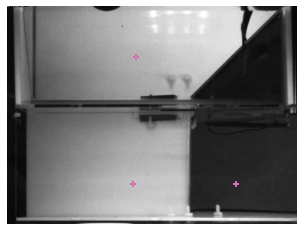

In [74]:
plot_LG_preds(arr_for_test, pred_mean_reshaped, pred_cov_reshaped)

In [98]:
# creating inds
def create_ind_list(num_views):
    ind_list = []
    for i in range(num_views):
        ind_list.append(np.array([i, i+num_views]))
    return ind_list
create_ind_list(3)

[array([0, 3]), array([1, 4]), array([2, 5])]

In [95]:
List1 = [np.array([0, 3]),
                               np.array([1, 4]),
                               np.array([2, 5])]
List2 = [np.array([0, 3])]
#check =  any(item in List1 for item in List2)
#print(check)
#print((List1[0]==List2[0]).all())
#print(List2[0])
for i in List1:
    for j in List2:
        print(i)
        print(all(i==j))

[0 3]
True
[1 4]
False
[2 5]
False


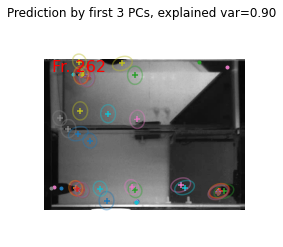

In [58]:
plot_all_covs = True
# now plotting. for each frame and body part, pick the relevant covariances to show.
# mark the points by colors
# mark the missing points by missing circles
# In general we WANT to loop over bps here just to have colors for each
for i in range(arr_for_test.shape[1]): # arr_for_test.shape[1], loop over frames, should be arr_for_test.shape[-1]
    plt.cla()
    plt.axis('off')
    plt.imshow(images[i,:,:,0], "gray")
    for bp in range(arr_for_test.shape[-1]): # loop over body parts, should be arr_for_test.shape[0] 
        plt.scatter(arr_for_test[:3,i,bp].flatten(), 
                    arr_for_test[3:,i,bp].flatten(), 
                    color = color[bp],
                   marker = ".")
        plt.scatter(pred_mean_reshaped[:3,i,bp].flatten(), 
                    pred_mean_reshaped[3:,i,bp].flatten(), 
                    color = color[bp],
                    marker = '+')
        # get inds of missing obs
        if plot_all_covs:
            missing_obs_list = [np.array([0, 3]),
                               np.array([1, 4]),
                               np.array([2, 5])]
        else:
            missing_obs_list = extract_missing_ind_pairs( \
                                                         arr_for_test[:,i,bp])
        bp_covariance_all = pred_cov_reshaped[:,:, i, bp]
        
        for inds in missing_obs_list:
            # extract covariance
            cov = LG_model.extract_blocks_from_inds(inds, bp_covariance_all)
            mean = pred_mean_reshaped[inds,i,bp].reshape(-1,1)
            #plot_conf_ellipse(cov, mean, 0.95, color[bp],2)
            x,y,stacked = make_meshgrid(mean, 100)
            #print(stacked.shape)
            d = mahalanobis_distance(cov=cov, mean=mean, stacked_meshgrid=stacked)
            plt.contour(x,y,d,[3.], colors = color[bp], alpha=0.4)
            #px1_x2 = scipy.stats.multivariate_normal(
            #mean.squeeze(), cov)
            #x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
            #pos = np.dstack((x, y))
            #contours = plt.contour(x,y, px1_x2.pdf(pos), \
            #                       2, alpha=0.4, colors= color[bp].reshape(-1,4))
            ##plt.clabel(contours, inline=True, fontsize=8)
    
    plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_[:num_PCs])))
    plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 16)
    plt.savefig(points_dir / ('im_%04d.png' %i))


In [125]:
missing_obs_list

[]

(6, 263, 10)


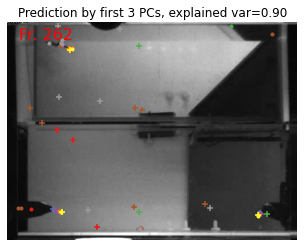

In [116]:
print(pred_mean_reshaped.shape)
# now plotting. for each frame and body part, pick the relevant covariances to show.
# mark the points by colors
# mark the missing points by missing circles
# In general we WANT to loop over bps here just to have colors for each
for i in range(arr_for_test.shape[1]): # loop over frames, should be arr_for_test.shape[-1]
    plt.cla()
    plt.axis('off')
    plt.imshow(images[i,:,:,0], "gray")
    for bp in range(arr_for_test.shape[-1]): # loop over body parts, should be arr_for_test.shape[0] 
        plt.scatter(arr_for_test[:3,i,bp].flatten(), 
                    arr_for_test[3:,i,bp].flatten(), 
                    color = color[bp],
                   marker = ".")
        plt.scatter(pred_mean_reshaped[:3,i,bp].flatten(), 
                    pred_mean_reshaped[3:,i,bp].flatten(), 
                    color = color[bp],
                    marker = '+')
        # get inds of missing obs
        missing_obs_list = extract_missing_ind_pairs(arr_for_test[:,i,bp])
        bp_covariance_all = pred_cov_reshaped[:,:, i, bp]
        
        for inds in missing_obs_list:
            # extract covariance
            cov = LG_model.extract_blocks_from_inds(inds, bp_covariance_all)
            mean = pred_mean_reshaped[inds,i,bp]
            px1_x2 = scipy.stats.multivariate_normal(
            mean.squeeze(), cov)
            x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
            pos = np.dstack((x, y))
            contours = plt.contour(x,y, px1_x2.pdf(pos), \
                                   2, alpha=0.4, colors= color[bp].reshape(-1,4))
            #plt.clabel(contours, inline=True, fontsize=8)
    
    plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_[:num_PCs])))
    plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 16)
    plt.savefig(points_dir / ('im_%04d.png' %i))

#inds_to_show = np.where(np.isnan(arr_for_test[:,i,]))[0]
#print(inds_to_show)
#cov = LG_model.extract_blocks_from_inds(inds_to_show, pred_cov)
#mean = pred_mean[inds_to_show]
#px1_x2 = scipy.stats.multivariate_normal(
#            mean.squeeze(), cov)
#        plt.cla()
#        plt.axis('off')
#        plt.imshow(images[i,:,:,0], "gray")
#        plt.scatter(arr_for_test[:3,i,:].flatten(), arr_for_test[3:,i,:].flatten())
#        #plt.scatter(preds_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten(), marker = '+')
#        plt.scatter(pred_mean_reshaped[:3,i,:].flatten(), pred_mean_reshaped[3:,i,:].flatten(), marker = '+')


#plt.legend(["true", "pred"])
#plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
#plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 16)
#plt.savefig(points_dir / ('im_%04d.png' %i))
#plt.xlabels = []

## Show the posterior inference for a single image

In [60]:
from LinearGaussianModel import LinearGaussianModel

In [271]:
print(pts_2d_reshaped.shape)
# pick one image 
test_im = 89
#plt.imshow(images[test_im,:,:,0], "gray")
# all the K x coords followed by all the K y coords
arr_for_test = np.concatenate((pts_2d_reshaped[:,:,:,0], 
                            pts_2d_reshaped[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
print(arr_for_test.shape)
# np.isnan(arr_for_test[:]).any() # True
print(arr_for_test[:, test_im, :])
test_x_missing = arr_for_test[:, test_im, 0] # either -1 or -2 are missing for test_im=143
print("-----")
print(test_x_missing) # this is a particular bodypart that's missing
nan_inds = np.where(np.isnan(test_x_missing))

(3, 263, 10, 2)
(6, 263, 10)
[[266.11111111 288.84       289.47553556 290.87555556 292.88
  294.16       242.52       187.92       140.88       141.8       ]
 [260.49473684 289.44444444 293.33333333 295.         298.33333333
  300.         235.04001    180.55555556 131.66666667 128.33333333]
 [         nan          nan          nan          nan          nan
  383.15789474 398.42105263          nan          nan          nan]
 [101.66666667 113.32       113.00888889 114.91555556 114.55111111
  114.520004    98.45333333  89.520004    69.840004    98.08      ]
 [349.25473684 365.55555556 366.11111111 367.22222222 368.33333333
  368.33333333 337.03998    318.33333333 326.66666667 317.22222222]
 [         nan          nan          nan          nan          nan
  365.26315789 334.21052632          nan          nan          nan]]
-----
[266.11111111 260.49473684          nan 101.66666667 349.25473684
          nan]


Now trying bishop's formulation which neads all evals.

In [272]:
pca = PCA(n_components=6, svd_solver='full')
pca.fit(arr_for_pca.T)
num_PCs = 3 # M

In [273]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

In [274]:
pca.explained_variance_

array([13798.44739609,  4631.693368  ,  3215.83600815,  1276.81117751,
         651.28911794,   586.84260102])

In [292]:
cov = pca.get_covariance() # C: (2K \times 2K)
components = pca.components_[:num_PCs,:] # P: (M \times 2K), our A 
mu = np.mean(arr_for_pca, axis=1) # b: 2K 
e_vals = pca.explained_variance_
D = np.diag(e_vals[:num_PCs]) # D: M \times M diagonal matrix with e-vals as entries
sigma_2 = np.mean(e_vals[num_PCs:])
PDP_TOP = np.linalg.multi_dot([components.T, D, components])
R = cov - PDP_TOP
alternat_resid = np.linalg.multi_dot([pca.components_[num_PCs:,:].T,
                                      np.diag(e_vals[num_PCs:]),
                                      pca.components_[num_PCs:,:]])
print(all((R-alternat_resid<0.0001).flatten()))

True


In [296]:
print((R-R.T<0.00001).flatten().all())

True


In [276]:
# assuming arbitrary R eqals I
W_ml = np.dot(components.T, scipy.linalg.sqrtm(D-np.eye(num_PCs)*sigma_2))

In [256]:
D - np.eye(num_PCs)*sigma_2

array([[12960.13309726,     0.        ,     0.        ],
       [    0.        ,  3793.37906917,     0.        ],
       [    0.        ,     0.        ,  2377.52170933]])

In [257]:
print(np.zeros((num_PCs,1)).shape)
print(W_ml.shape)
print(mu.shape)
print(np.eye(num_PCs).shape)
print(np.linalg.inv(np.eye(cov.shape[0])*sigma_2).shape)
cov.shape

(3, 1)
(6, 3)
(6,)
(3, 3)
(6, 6)


(6, 6)

In [277]:
# parametrizing by precision
LG_model = LinearGaussianModel(np.zeros((num_PCs,1)), 
                              np.eye(num_PCs), 
                               W_ml, mu, np.linalg.inv(np.eye(cov.shape[0])*sigma_2))

beloq was the previous formulation

In [167]:
# both obs and b are specified as 1d arrays currently (important for conditional). note that prior mean is 2d arr
# good post
cov = pca.get_covariance() # C: (2K \times 2K)
components = pca.components_ # P: (M \times 2K), our A 
mu = np.mean(arr_for_pca, axis=1) # b: 2K 
e_vals = pca.explained_variance_
D = np.diag(e_vals) # D: M \times M diagonal matrix with e-vals as entries
PDP_TOP = np.linalg.multi_dot([components.T, D, components])
R = cov - PDP_TOP
#print(cov.shape)
#print(components.shape)
#print(mu.shape)
#print(evals.shape)
#print(D.shape)
#print(R.shape)
#print(np.zeros((np.shape(D)[0])))

LG_model = LinearGaussianModel(np.zeros((np.shape(D)[0],1)), 
                              np.linalg.inv(D), 
                               components.T, mu, np.linalg.inv(R))
#ToDo: maybe make some asserts in init to check dims?

In [171]:
print(np.linalg.inv(D))

[[7.24719218e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.15903757e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.10961130e-04]]


In [168]:
all((R-R.T).flatten() < 0.001)
print(e_vals)
print(components.shape)

[13798.44739609  4631.693368    3215.83600815]
(3, 6)


In [184]:
print(scipy.linalg.sqrtm(D))
print(D)
print(np.sqrt(np.diag(D)))

[[117.46679274   0.           0.        ]
 [  0.          68.05654537   0.        ]
 [  0.           0.          56.70834161]]
[[13798.44739609     0.             0.        ]
 [    0.          4631.693368       0.        ]
 [    0.             0.          3215.83600815]]
[117.46679274  68.05654537  56.70834161]


In [214]:
AA = LG_model.prior_precision
print(AA)
print("=================")

# without any missing values, assuming all observed
BB = np.linalg.multi_dot(
           [LG_model.likelihood_A.T, 
            LG_model.likelihood_precision, 
            LG_model.likelihood_A])
print(BB)
print("=================")
# posterior covariance
Sig = np.linalg.inv(AA+BB)
print(Sig)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.54597543e+01 -3.86723770e-16 -8.35297575e-17]
 [-4.11854607e-16  4.52500819e+00 -8.28216318e-16]
 [-5.15611221e-17 -7.65664257e-16  2.83607438e+00]]
[[6.07542483e-02 4.25250265e-18 1.32291168e-18]
 [4.52884705e-18 1.80995207e-01 3.90772359e-17]
 [8.16604920e-19 3.61258794e-17 2.60683162e-01]]


In [215]:
#LG_model = LinearGaussianModel(mu, 
#                              prior_precision, 
#                               A, b, obs_precision))

In [278]:
# compute the posterior for one test obj
post_mean, post_cov = LG_model.compute_posterior(test_x_missing)
print("post_mean: \n {}".format(post_mean))
print("post_cov: \n {}".format(post_cov))

post_mean: 
 [[ 0.48042471]
 [-0.40551003]
 [ 0.41642638]]
post_cov: 
 [[ 0.06149149 -0.01078167 -0.0043884 ]
 [-0.01078167  0.35957848  0.02778725]
 [-0.0043884   0.02778725  0.35014314]]


In [279]:
post_cov-post_cov.T

array([[ 0.00000000e+00, -1.73472348e-18,  0.00000000e+00],
       [ 1.73472348e-18,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [280]:
# predict
pred_mean, pred_cov = LG_model.predict(post_mean, post_cov)

(6, 3)
(3, 1)
(6,)


In [281]:
pred_cov

array([[1197.80154188,  388.44270451,    5.03155513,   38.83048798,
          28.62015057,   16.74708614],
       [ 388.44270451, 1271.77802418,   53.96560836,  -31.89464337,
         -12.8706212 ,  -19.27683476],
       [   5.03155513,   53.96560836, 1427.34797211, -484.26563565,
         260.4533351 ,  293.57913315],
       [  38.83048798,  -31.89464337, -484.26563565, 1359.67762089,
          16.20185982,  -25.30273134],
       [  28.62015057,  -12.8706212 ,  260.4533351 ,   16.20185982,
        1392.42392862,  543.20755218],
       [  16.74708614,  -19.27683476,  293.57913315,  -25.30273134,
         543.20755218, 1374.28496235]])

In [282]:
inds_to_show = np.where(np.isnan(test_x_missing))[0]
print(inds_to_show)
cov_test = LG_model.extract_blocks_from_inds(inds_to_show, pred_cov) # Warning:running this cov results in problems
mean = pred_mean[inds_to_show]
px1_x2 = scipy.stats.multivariate_normal(
            mean.squeeze(), cov_test)

[2 5]


In [283]:
x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
pos = np.dstack((x, y))

In [284]:
print(cov_test)

[[1427.34797211  293.57913315]
 [ 293.57913315 1374.28496235]]


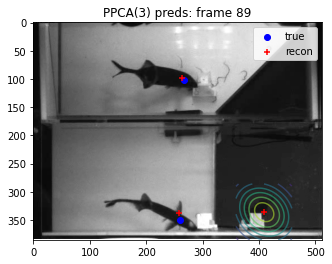

In [285]:
# show an image
# show mean prediction
plt.imshow(images[test_im,:,:,0], "gray")
plt.scatter(test_x_missing[:3], test_x_missing[3:], color = "blue")
plt.scatter(pred_mean[:3], pred_mean[3:], marker = '+', color = "red")
# plot cov just for one missing obs
CS = plt.contour(x,y, px1_x2.pdf(pos), alpha=0.6)
plt.legend(['true', 'recon', "bla"])
plt.title("PPCA(3) preds: frame {}".format(test_im))
plt.savefig(os.path.join(plot_folder, 'infill_ppca_frame{}.png'.format(test_im)))

In [102]:
# loop over frames and bodyparts get pred_mean and pred_cov for each. then decide what to plot
arr_for_test = np.concatenate((pts_2d_reshaped[:,:,:,0], 
                            pts_2d_reshaped[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
print(arr_for_test.shape)
arr_squeezed = arr_for_test.reshape(6,-1)
print(arr_squeezed.shape)
#test_x_missing = arr_for_test[:, test_im, 0]

(6, 263, 10)
(6, 2630)


In [226]:
LG_model = LinearGaussianModel(np.zeros((num_PCs,1)), 
                              np.eye(num_PCs), 
                               W_ml, mu, np.linalg.inv(np.eye(cov.shape[0])*sigma_2))

ValueError: operands could not be broadcast together with shapes (6,6) (2,2) 

In [103]:
# now loop over the last dimension and do posterior prediction. could be batched in the future.
# liam's parametrization
#LG_model = LinearGaussianModel(np.zeros((np.shape(D)[0],1)), 
#                              np.linalg.inv(D), 
#                               components.T, mu, np.linalg.inv(R))
# parametrizing by precision, bishop's ml solution
LG_model = LinearGaussianModel(np.zeros((num_PCs,1)), 
                              np.eye(num_PCs), 
                               W_ml, mu, np.linalg.inv(np.eye(cov.shape[0])*sigma_2))

pred_mean = np.zeros_like(arr_squeezed)
pred_cov = np.zeros((arr_squeezed.shape[0],arr_squeezed.shape[0], arr_squeezed.shape[1]))
for i in range(arr_squeezed.shape[1]):
    # compute posterior
    post_mean, post_cov = LG_model.compute_posterior(arr_squeezed[:,i]) # a single frame and body part
    # predict
    mean, cov = LG_model.predict(post_mean, post_cov)
    pred_mean[:,i], pred_cov[:,:,i] = mean.squeeze(), cov

NameError: name 'W_ml' is not defined

In [242]:
# reshape outputs
pred_mean_reshaped = pred_mean.reshape(arr_for_test.shape)
pred_cov_reshaped = pred_cov.reshape(arr_for_test.shape[0], 
                                     arr_for_test.shape[0], 
                                     arr_for_test.shape[1], 
                                     arr_for_test.shape[2])

In [243]:
pred_cov_reshaped.shape

(6, 6, 263, 10)

In [243]:
#extract_missing_ind_pairs(arr_for_test[:,i,bp])

[0 2 3 5]


[array([0, 3]), array([2, 5])]

(6, 263, 10)


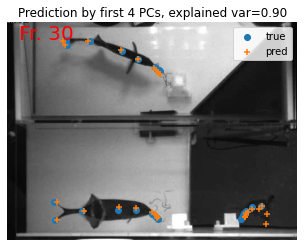

In [220]:
print(pred_mean_reshaped.shape)
# now plotting. for each frame and body part, pick the relevant covariances to show.
# mark the points by colors
# mark the missing points by missing circles
# In general we WANT to loop over bps here just to have colors for each
i = 50
for i in range(arr_for_test.shape[-1]): # loop over frames
inds_to_show = np.where(np.isnan(arr_for_test[:,i,]))[0]
print(inds_to_show)
cov = LG_model.extract_blocks_from_inds(inds_to_show, pred_cov)
mean = pred_mean[inds_to_show]
px1_x2 = scipy.stats.multivariate_normal(
            mean.squeeze(), cov)
plt.cla()
plt.axis('off')
plt.imshow(images[i,:,:,0], "gray")
plt.scatter(arr_for_test[:3,i,:].flatten(), arr_for_test[3:,i,:].flatten())
#plt.scatter(preds_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten(), marker = '+')
plt.scatter(pred_mean_reshaped[:3,i,:].flatten(), pred_mean_reshaped[3:,i,:].flatten(), marker = '+')


plt.legend(["true", "pred"])
plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 20)
plt.savefig(points_dir / ('im_%04d.png' %i))
plt.xlabels = []

In [244]:
arr_for_test.shape

(6, 263, 10)

In [83]:
color[0]

array([0.89411765, 0.10196078, 0.10980392, 1.        ])

In [148]:
range(arr_for_test.shape[-1])

range(0, 10)

In [150]:
np.linalg.inv(params['prior_precision'])

array([[13798.44739609,     0.        ,     0.        ],
       [    0.        ,  4631.693368  ,     0.        ],
       [    0.        ,     0.        ,  3215.83600815]])

In [153]:
evals, evecs = np.linalg.eig(cov)


array([669.56451094, 289.61822772])

(6, 263, 10)


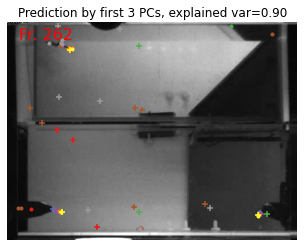

In [147]:
print(pred_mean_reshaped.shape)
# now plotting. for each frame and body part, pick the relevant covariances to show.
# mark the points by colors
# mark the missing points by missing circles
# In general we WANT to loop over bps here just to have colors for each
for i in range(arr_for_test.shape[1]): # loop over frames, should be arr_for_test.shape[-1]
    plt.cla()
    plt.axis('off')
    plt.imshow(images[i,:,:,0], "gray")
    for bp in range(arr_for_test.shape[-1]): # loop over body parts, should be arr_for_test.shape[0] 
        plt.scatter(arr_for_test[:3,i,bp].flatten(), 
                    arr_for_test[3:,i,bp].flatten(), 
                    color = color[bp],
                   marker = ".")
        plt.scatter(pred_mean_reshaped[:3,i,bp].flatten(), 
                    pred_mean_reshaped[3:,i,bp].flatten(), 
                    color = color[bp],
                    marker = '+')
        # get inds of missing obs
        missing_obs_list = extract_missing_ind_pairs(arr_for_test[:,i,bp])
        bp_covariance_all = pred_cov_reshaped[:,:, i, bp]
        
        for inds in missing_obs_list:
            # extract covariance
            cov = LG_model.extract_blocks_from_inds(inds, bp_covariance_all)
            mean = pred_mean_reshaped[inds,i,bp]
            plot_conf_ellipse(cov, mean, 0.95, color[bp],2)
            #px1_x2 = scipy.stats.multivariate_normal(
            #mean.squeeze(), cov)
            #x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
            #pos = np.dstack((x, y))
            #contours = plt.contour(x,y, px1_x2.pdf(pos), \
            #                       2, alpha=0.4, colors= color[bp].reshape(-1,4))
            ##plt.clabel(contours, inline=True, fontsize=8)
    
    plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_[:num_PCs])))
    plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 16)
    plt.savefig(points_dir / ('im_%04d.png' %i))

#inds_to_show = np.where(np.isnan(arr_for_test[:,i,]))[0]
#print(inds_to_show)
#cov = LG_model.extract_blocks_from_inds(inds_to_show, pred_cov)
#mean = pred_mean[inds_to_show]
#px1_x2 = scipy.stats.multivariate_normal(
#            mean.squeeze(), cov)
#        plt.cla()
#        plt.axis('off')
#        plt.imshow(images[i,:,:,0], "gray")
#        plt.scatter(arr_for_test[:3,i,:].flatten(), arr_for_test[3:,i,:].flatten())
#        #plt.scatter(preds_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten(), marker = '+')
#        plt.scatter(pred_mean_reshaped[:3,i,:].flatten(), pred_mean_reshaped[3:,i,:].flatten(), marker = '+')


#plt.legend(["true", "pred"])
#plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
#plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 16)
#plt.savefig(points_dir / ('im_%04d.png' %i))
#plt.xlabels = []

In [93]:
# make video from these images
image_folder = points_dir
import cv2
import os
im_list = os.listdir(image_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(image_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('video_PPCA_3.mp4',
                      #cv2.VideoWriter_fourcc(*'XVID'),
                    #cv2.VideoWriter_fourcc(*'MJPG'),
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      #cv2.VideoWriter_fourcc(*'DIVX'), 
                      2, size) # 
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [97]:
print(image_folder)
print(filename)
str(image_folder)+filename

/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose/PCA_reproj
im_0262.png


'/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose/PCA_reprojim_0262.png'

In [109]:
np.sqrt(np.diag(cov))

array([25.78644984, 21.33333333])

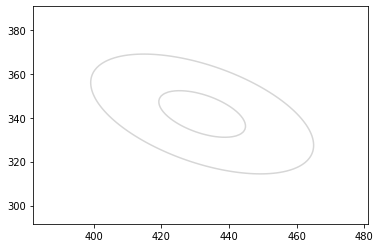

In [110]:
px1_x2 = scipy.stats.multivariate_normal(
            mean.squeeze(), cov)
x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
pos = np.dstack((x, y))
contours = plt.contour(x,y, px1_x2.pdf(pos), \
                                   2, alpha=0.4, colors= color[bp].reshape(-1,4))

### Plotting covariance ellipses
Let $x \in \mathbb{R}^2$ and $\Sigma \in \mathbb{R}^{2 \times 2}$ p.s.d covariance matrix. Since a $x$ affects the multivariate normal only theough the exponenet, The level set is given by the mahalanobis distance, which is a quadratic form
$$
L(x) = x^{\top}\Sigma^{-1}x
$$
Perform eigen decomposition of $\Sigma{-1}$
$$
\Sigma^{-1} = U \Lambda U^{\top}
$$
obtaining
$$
L(x) = \underbrace{x^{\top}U}_{:=\tilde{x}^{\top}} \Lambda \underbrace{U^{\top}x }_{:=\tilde{x}}
$$
now


where $U$ is a matrix with eigenvectors as columns and $\Lambda$ has the eigen values as its diagonal entries.

In [143]:
cov_fake = np.array([[0.25, 0.2], [0.2, 0.25]])
cov_fake

array([[0.25, 0.2 ],
       [0.2 , 0.25]])

In [247]:
cov

array([[1427.34797211,  293.57913315],
       [ 293.57913315, 1374.28496235]])

In [139]:
print(evals)
print(evecs)
print(evecs.T)
print(np.diag(evals))

[0.00134951 0.00263823]
[[-0.70459758 -0.25542693]
 [ 0.70960711 -0.96682836]]
[[-0.70459758  0.70960711]
 [-0.25542693 -0.96682836]]
[[0.00134951 0.        ]
 [0.         0.00263823]]


In [121]:
def mahalanobis_func(value_vec, mean_vec, cov_mat):
    '''all 2X2'''
    diff = value_vec - mean_vec 
    return np.sqrt(np.linalg.multi_dot([diff.T, 
                                       np.linalg.inv(cov_mat), 
                                       diff]))

In [117]:
def ellipse_func(x, coeffs, C ):
    '''data: (x,y)'''
    y = np.sqrt(1/coeffs[-1]*(C - coeffs[0]* (x**2)))
    return y
    

In [131]:
x = np.linspace(5,10,1)
y = ellipse_func(x, [1.3, 6.0], 3.)
y.shape

/anaconda3/envs/bundle-adjust/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


(1,)

In [161]:
rand_3d = np.random.normal(size = (10, 100, 2))

In [163]:
rand_3d.dot(np.random.normal(size = (2,1))).shape

(10, 100, 1)

In [28]:
stacked = np.stack([x,z], axis=-1)
(stacked[:,:,0] == x).flatten().all()
stacked.shape
#np.linalg.multi_dot([stacked, np.random.normal(size = (2,2)),  ])
#stacked.dot(np.random.normal(size = (100, 1000, 2,2))).shape

(100, 1000, 2)

In [25]:
#arr_1 = np.random.normal(size = (100, 1000, 2,2))
arr_1 = np.random.normal(size = (2,2))
arr_2 = np.random.normal(size = (100, 1000, 2,1))
out = mahalanobis_distance(arr_1, arr_2)
out.shape

(100, 1000, 1, 1)

In [36]:
def mahalanobis_distance(cov, stacked_meshgrid):
    '''stacked_meshgrid: shape(,,2,1)
        cov: shape(2,2)'''
    assert(stacked_meshgrid.shape[-2:] == (2,1))
    out = stacked_meshgrid.transpose(0, 1, 3, 2)@ \
    np.linalg.inv(cov)@stacked_meshgrid
    return out.reshape(out.shape[0], out.shape[1])

In [20]:
(np.linalg.inv(np.linalg.inv(arr_1)) - arr_1 < 0.001).all()

True

(100, 1000)
(100, 1000)


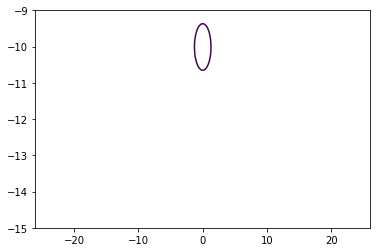

In [27]:
z = -np.linspace(9,15,100)
x = np.linspace(-26,26,1000)

x,z = np.meshgrid(x,z)
print(x.shape)
print(z.shape)

Z = -np.exp(-0.05*z) +4*(z+10)**2 
X = x**2


plt.contour(x,z,(X+Z),[0])

In [159]:
Z.shape

(100, 1000)

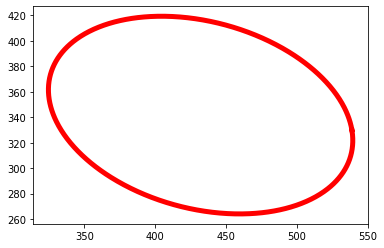

In [138]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal,chi2
from scipy.linalg import sqrtm, inv
Sigma = np.copy(cov)
confidence = .95
radius = np.sqrt( chi2.isf(1-confidence, df=n) )
T = np.linspace(0, 2*np.pi, num=1000)
circle = radius * np.vstack([np.cos(T), np.sin(T)])
x, y = sqrtm(Sigma) @ circle

plt.plot(x+mean[0], y+mean[1], '-r', linewidth=5)

In [124]:
mahalanobis_func(np.ones(2), np.zeros(2), np.eye(2))

1.4142135623730951

In [123]:
x, y = np.mgrid[mean[0]-50:mean[0]+50:1., mean[1]-50:mean[1]+50:1.]
pos = np.dstack((x, y))
contours = plt.contour(x,y, mahalanobis_func(pos, mean, cov), \
                                   3., alpha=0.4, colors= color[bp].reshape(-1,4))




LinAlgError: 3-dimensional array given. Array must be two-dimensional

In [104]:
import ffmpeg
(
    ffmpeg
    .input(str(image_folder)+'/*.png', pattern_type='glob', framerate=25)
    .output('movie.mp4')
    .run()
)

AttributeError: module 'ffmpeg' has no attribute 'input'

In [ ]:
for i in range(preds_reshaped.shape[1]):
    plt.cla()
    plt.axis('off')
    plt.imshow(images[i,:,:,0], "gray")
    plt.scatter(pts_2d_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten())
    plt.scatter(preds_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten(), marker = '+')
    plt.legend(["true", "pred"])
    plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
    plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 20)
    plt.savefig(points_dir / ('im_%04d.png' %i))
    plt.xlabels = []

In [ ]:
z_hat = calc_zhat_w_pinv(components.T, test_x_missing, mu)
print(z_hat)

In [81]:
test_obs = np.array([30.0, 30.0])
test_obs[1] = None
print(test_obs)

[30. nan]


In [82]:
np.where(~np.isnan(test_obs))[0]

array([0])

In [83]:
post_mean, post_cov = LG_model.compute_posterior(test_obs)
print("post_mean: \n {}".format(post_mean))
print("post_cov: \n {}".format(post_cov))

post_mean: 
 [[16.]
 [ 1.]]
post_cov: 
 [[0.5 0. ]
 [0.  1. ]]


In [84]:
pred_mean, pred_cov = LG_model.predict(post_mean, post_cov)

(2, 2)
(2, 1)
(2,)


In [87]:
print(pred_mean)
print(post_cov)

[[16.]
 [ 1.]]
[[0.5 0. ]
 [0.  1. ]]


In [ ]:
# test simple posterior mean
# make contour plot 

In [1004]:
# # successful test
# test_cov = np.array([[11, 12, 13],[21, 22, 23], [31,32,33]])
# good_inds = np.array([0, 1])
# LG_model.extract_blocks_from_inds(good_inds, test_cov)

array([[11, 21],
       [12, 22]])

In [969]:
good_inds = np.array([0, 2])
keep_inds = [(i,j) for i in good_inds for j in good_inds]

In [971]:
keep_inds

[(0, 0), (0, 2), (2, 0), (2, 2)]

In [994]:
(np.diff(good_inds)>=0).all()

True

In [992]:
# passes the test. 
good_inds = np.array([0, 1])
assert (np.diff(good_inds)>=0).all() # ensure good_inds are sorted
row_inds = np.tile(good_inds, (len(good_inds)))
col_inds = np.repeat(good_inds, len(good_inds), axis=0)
print(row_inds)
print(col_inds)
test_cov[row_inds, col_inds].reshape(len(good_inds), len(good_inds))

[0 1 0 1]
[0 0 1 1]


array([[11, 21],
       [12, 22]])

In [976]:
test_cov[[0,0,2,2], [0,2,0,2]].reshape(len(good_inds), len(good_inds))

array([[11, 13],
       [31, 33]])

In [999]:
LG_model = LinearGaussianModel(np.array([2,1]), np.eye(2), np.eye(2), np.array([[2],[1]]), np.eye(2))

TypeError: _multidot_dispatcher() takes 1 positional argument but 3 were given

In [951]:
LG_model.compute_like_mean(np.tile([[2],[1]], (1,6))) # looks fine

array([[4., 4., 4., 4., 4., 4.],
       [2., 2., 2., 2., 2., 2.]])

In [927]:
np.tile([[2],[1]], (1,6))

array([[2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1]])

## The PINV method

In [746]:
print(pts_2d_reshaped.shape)
# pick one image 
test_im = 89
#plt.imshow(images[test_im,:,:,0], "gray")
# all the K x coords followed by all the K y coords
arr_for_test = np.concatenate((pts_2d_reshaped[:,:,:,0], 
                            pts_2d_reshaped[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
print(arr_for_test.shape)
# np.isnan(arr_for_test[:]).any() # True
print(arr_for_test[:, test_im, :])
test_x_missing = arr_for_test[:, test_im, 0] # either -1 or -2 are missing for test_im=143
print("-----")
print(test_x_missing) # this is a particular bodypart that's missing
nan_inds = np.where(np.isnan(test_x_missing))

(3, 263, 10, 2)
(6, 263, 10)
[[266.11111111 288.84       289.47553556 290.87555556 292.88
  294.16       242.52       187.92       140.88       141.8       ]
 [260.49473684 289.44444444 293.33333333 295.         298.33333333
  300.         235.04001    180.55555556 131.66666667 128.33333333]
 [         nan          nan          nan          nan          nan
  383.15789474 398.42105263          nan          nan          nan]
 [101.66666667 113.32       113.00888889 114.91555556 114.55111111
  114.520004    98.45333333  89.520004    69.840004    98.08      ]
 [349.25473684 365.55555556 366.11111111 367.22222222 368.33333333
  368.33333333 337.03998    318.33333333 326.66666667 317.22222222]
 [         nan          nan          nan          nan          nan
  365.26315789 334.21052632          nan          nan          nan]]
-----
[266.11111111 260.49473684          nan 101.66666667 349.25473684
          nan]


In [747]:
components.shape

(3, 6)

In [748]:
def calc_zhat_w_pinv(P, x, mu):
    """
    P: (2KXM) matrix projecting a latent z into the observation x 
    x: observation (2K-dim vec), K x's followed by K y's. may contain nans
    mu: data mean (6-dim vec)
    """
    valid_inds = np.where(~np.isnan(x))[0]
    diff = (x[valid_inds]-mu[valid_inds]).reshape(-1,1)
    return np.linalg.pinv(P[valid_inds,:]).dot(diff)

In [749]:
z_hat = calc_zhat_w_pinv(components.T, test_x_missing, mu)
print(z_hat)

[[ 58.75583878]
 [-37.90093491]
 [ 29.79222031]]


In [750]:
recon_infilled = (components.T).dot(z_hat) + mu.reshape(-1,1)
print(recon_infilled)

[[266.27365608]
 [260.34721217]
 [411.16082807]
 [101.64588413]
 [349.24352231]
 [346.86614788]]


In [751]:
print(recon_infilled.squeeze(), test_x_missing)

[266.27365608 260.34721217 411.16082807 101.64588413 349.24352231
 346.86614788] [266.11111111 260.49473684          nan 101.66666667 349.25473684
          nan]


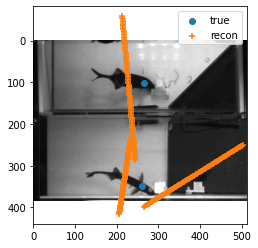

In [887]:
plt.imshow(images[test_im,:,:,0], "gray")
plt.scatter(test_x_missing[:3], test_x_missing[3:])
plt.scatter(recon_infilled[:3], recon_infilled[3:], marker = '+')
plt.legend(['true', 'recon'])
plt.savefig(os.path.join(plot_folder, 'test_infill.png'))

In [836]:
print(arr_for_test.shape)
print(pts_2d.shape)
print(pts_2d_reshaped.shape)
print(preds_reshaped.shape)

(6, 263, 10)
(3, 2630, 2)
(3, 263, 10, 2)
(3, 263, 10, 2)


In [873]:
# true labels with occasional missing points
arr_true = np.concatenate((pts_2d_reshaped[:,:,:,0], 
                            pts_2d_reshaped[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
# PCA reconstructions; any body part that is invisible from one view is assigned nans in all views
arr_pca_pred = np.concatenate((preds_reshaped[:,:,:,0], 
                            preds_reshaped[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views

In [874]:
arr_pca_pred.shape

(6, 263, 10)

In [877]:
print(arr_pca_pred[:,110,2])
print(arr_true[:,110,2])

[nan nan nan nan nan nan]
[         nan 164.21052632 494.73684211          nan 210.
 218.42105263]


In [878]:
test_pca_arr = np.copy(arr_pca_pred) # for testing purpuses 
nan_frames_bps = np.isnan(arr_pca_pred).any(axis=0) # (num_frames, num_bodyparts)
nan_frames_bps = np.tile(nan_frames_bps, (arr_pca_pred.shape[0],1,1))
test_pca_arr[nan_frames_bps] = np.copy(arr_true[nan_frames_bps])

In [871]:
*np.where(nan_frames_bps)

SyntaxError: can't use starred expression here (<ipython-input-871-0f4d1d9428ba>, line 4)

In [886]:
print("pca_pred_before modifications \n", arr_pca_pred[:,110,2])
print("pca_pred_after modifications \n", test_pca_arr[:,110,2])
print("true arr \n", arr_true[:,110,2])

pca_pred_before modifications 
 [nan nan nan nan nan nan]
pca_pred_after modifications 
 [         nan 164.21052632 494.73684211          nan 210.
 218.42105263]
true arr 
 [         nan 164.21052632 494.73684211          nan 210.
 218.42105263]


In [854]:
test_pca_arr[nan_frames_bps].shape

(5274,)

In [851]:
np.tile(nan_frames_bps, (arr_pca_pred.shape[0],1,1)).shape

(6, 263, 10)

In [847]:
test_pca_arr[:, nan_frames_bps].shape

(6, 879)

Text(0, 0.5, 'bp')

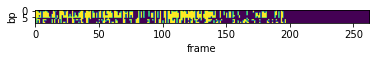

In [845]:
plt.imshow(np.isnan(arr_pca_pred).any(axis=0).T)
plt.xlabel('frame')
plt.ylabel('bp')

What we need to do:
1. take the rows with nan values in `pts_2d_reshaped`, do infilling, and save. 
2. 

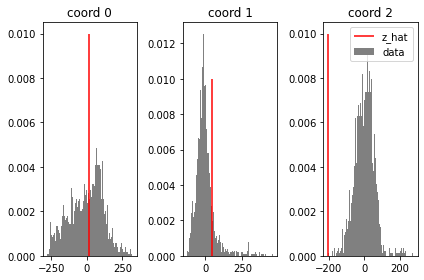

In [717]:
# plot that compares a single set of M z coords against the distribution of observed z coords
fig, ax = plt.subplots(1, reduced_data.shape[-1])
for i in range(reduced_data.shape[-1]):
    ax[i].hist(reduced_data[:,i], bins = 100, density=True, color = 'gray');
    ax[i].set_title("coord %i" %i)
    ax[i].vlines(x=z_hat[i], ymin =0, ymax = 0.01, color = 'red')
plt.legend(['z_hat', 'data'])
#fig.suptitle
fig.tight_layout()
plt.savefig(os.path.join(plot_folder, 'latent_coords.png'))#plt.vlines
#plt.hist(reduced_data[-1])

In [819]:
#reduced_data.shape
latent_means = np.mean(reduced_data, axis=0)
latent_min_vals = np.min(reduced_data, axis=0)
latent_max_vals = np.max(reduced_data, axis=0)

In [820]:
num_steps = 100
traversals = np.linspace(latent_min_vals, latent_max_vals, num_steps)
means = np.tile(latent_means, (num_steps, 1))
print(means.shape)
print(traversals.shape)

(100, 3)
(100, 3)


In [821]:
#z_hat_mat = means
#z_hat_mat[:,0] = traversals[:,0]
#z_hat_mat.shape
#z_hat.shape

In [822]:
#np.tile(mu.reshape(-1,1),(1,num_steps)).shape

In [823]:
#traversals.shape[-1]

In [824]:
#traversals[:,0]

In [825]:
#recon_infilled = []
#z_hat_mat = []
#print(d)
#z_hat_mat = np.copy(means)
#print(z_hat_mat.shape)
#z_hat_mat[:,1] = np.copy(traversals[:,1])
#z_hat_mat = z_hat_mat.T
#print(z_hat_mat.shape)
#print(components.T.shape, z_hat_mat.shape, mu_mat.shape)
#recon_infilled = (components.T).dot(z_hat_mat) + mu_mat
##print(recon_infilled.shape)
#plt.imshow(images[test_im,:,:,0], "gray")
#plt.scatter(recon_infilled[:3, :][:], recon_infilled[3:, :][:])

verify this!

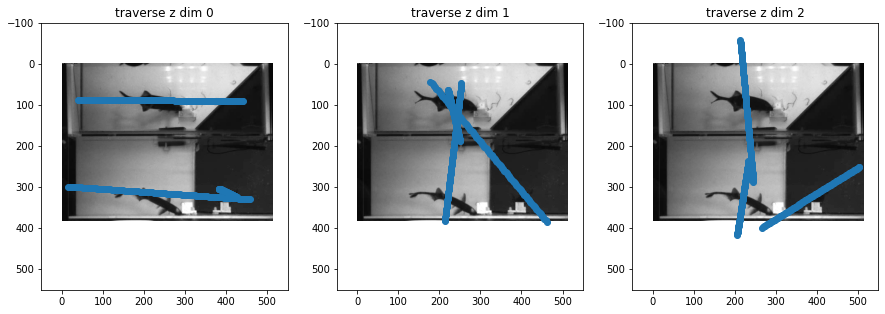

In [831]:
# checkout what happens when you move z_hat
# pick dim 0
mu_mat = np.tile(mu.reshape(-1,1),(1,num_steps))
fig, ax = plt.subplots(1, reduced_data.shape[-1], figsize = (15,10))
for d in range(traversals.shape[-1]):
    recon_infilled = []
    z_hat_mat = []
    z_hat_mat = np.copy(means)
    z_hat_mat[:,d] = np.copy(traversals[:,d])
    z_hat_mat = z_hat_mat.T
    #print(components.T.shape, z_hat_mat.shape, mu_mat.shape)
    recon_infilled = (components.T).dot(z_hat_mat) + mu_mat
    ax[d].imshow(images[test_im,:,:,0], "gray")
    ax[d].scatter(recon_infilled[:3, :][:], recon_infilled[3:, :][:])
    ax[d].set_title('traverse z dim %i'% d)
    ax[d].set_xlim(-50, 550)
    ax[d].set_ylim(550, -100)
plt.savefig(os.path.join(plot_folder, 'latent_traversals.png'))#plt.vlines


#print(recon_infilled.shape)

In [183]:
# # using filter() + lambda  
# # to get string with substring
# res = []
# for subs in bp_to_keep:
#     res.append(list(filter(lambda x: subs in x, skeleton_name_list)))
#     # below returns the names
#     #res.append(list(filter(lambda x: subs in x, skeleton_name_list)))

In [ ]:
# strings = skeleton_name_list
# substring = 'tail'
# for substring in bp_to_keep:
#     strings_with_substring.append([string for string in strings if substring in string])

In [514]:
# offset = False
# # (num views, num frames, num points per frame, 2)
# pts_array_2d_joints = np.empty(
#     shape=(len(view_names), pts_array.shape[0], num_analyzed_body_parts, 2)
# )

# confidences_bp = np.empty(
#     shape=(len(view_names), pts_array.shape[0], num_analyzed_body_parts)
# )

# for i, view_name in enumerate(view_names):
#     # Select rows from indices
#     view_indices = multiview_name_to_idx[view_name]
#     view_points = pts_array[:, view_indices, :]
#     if offset:
#         view_points[:, :, 0] -= img_settings["width_lims"][i][0]
#         view_points[:, :, 1] -= img_settings["height_lims"][i][0]
#     pts_array_2d_joints[i, :, :, :] = view_points

In [513]:
# # now want to pick certain body parts
# # first create an array for one body part from three views
# separated_list = [j.split('_') for j in skeleton_name_list]
# separated_list